In this notebook, I will work through MNIST data and look at some classification algorithms

# Importing common libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the Data
We can use `sklearn.datasets.fetch_openml` to get the MNIST data.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

The MNIST data is already broken out into features and labels

In [3]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

From the shape, we can see it has 7000 rows and 784 columns. Each row has 784 features which represents a 28x28 image.
Let's look at the first digit

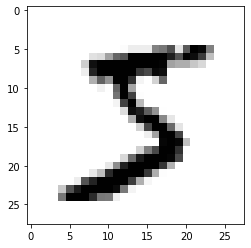

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.show()

As we can see, it's a '5'. Let's look at the label for this row.

In [6]:
y[0]

'5'

Yay! it's indeed a '5'. Thing to note here is that the target values are stored in string format, so let's convert the target values into integers.

In [5]:
y = y.astype(np.uint8)

# Splitting the Data into Training and Test sets

The data is already split into training and test data based on the index. First 60000 rows are training set and the remaining ones are test set. So we can easily split the data without the need of any librarires

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Machine Learning Algorithms

## Binary Algorithms:
- __Stochastic Gradient Descent (SGD) Classifier__
    - Capable of handling very large datasets efficiently, as SGD deals with training instances independently
    - Suited for online training

## Multiclass Classification

Multiclass Classifiers _(also called as Multinomial Classifiers)_ can distinguish between more than two classes.

Some algorithms (such as Random Forest Classifiers or Naive Bayes Classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machine Classifiers or Linear Classifiers) are strictly Binary Classifiers. However, there are various strategies that we can use to perform Multiclass Classification using Binary Classifierrs:

- __One-versus-the-rest__ (OvA):
    - One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 Binary Classifierrs, one for each digit (0-detector, 1-detector, and so on). 
    - Then when we want to classsify an image, we get the decision score from each classifier for that image and we select the class whose classifier output (decision score) is the highest.
    - For most Binay Classification algorithms, OvA is preferred.

- __One-versus-One__ (OvO):
    - Another strategy is to train a Binary Classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on.
    - If there are N classes, then we need to train N$*$(N-1)$/$2 classifiers. For our problem, this means training 45 Binary Classifiers.
    - When we want to classify an image, we have to run the image through all 45 classifiers and see which class wins the most duels.
    - The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes it must distinguish.
    - Some algorithms (such as Support Vector Machine Classifer) scale poorly with the size of training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifier for which it uses OvO). Let's try this with our `SGDClassifier`:

Since we are working with Binary Algorithms, let's focus on only one digit '5'

In [8]:
y_train_5 = (y_train == 5)
y_test_y = (y_test == 5)

#### Stochastic Gradient Descent (SGD) Classifier:

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Now let's predict the value of the first row using this model

In [10]:
sgd_clf.predict([some_digit])

array([ True])

As we can see the classifier predicts the image correctly

# Evaluating the Model

- __Cross Validation Score__
    - For a classification model, this approach isn't used as often
- __Confusion Matrix__
    - Much better way to evaluate a classification model
    - We need set of predictions in order to compute confusion matrix
    - Overall understanding about the predictions and errors
    - Using the confusion matrix, we can calculate various evaluating metrics:
    - __Precision:__
        - How many predictions were actually correct
        - True Positive / (True Positive + False Positive)
    - __Recall:__
        - How many true class we are able to catch
        - True Positive / (True Positive + False Negative)
    - __F1 Score:__
        - It is the harmonic mean of precision and reacall, that means it gives much more weight to the lower value
        - 2 * (Precision * Recall) / (Precision + Recall)
- __Precision vs Recall Graphs__
    - Precision Recall Curve
    - Precision vs Recall
    - Receiver Operator Curve (ROC)
        - Another common tool used with binary classifiers
        - Similar to precision recall cureve, but instead of plotting precision vs recall, the ROC curve plots true positive rate (another name for recall) against false positive rate
        - The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus TNR. The TNR is also called specificity.
        - Hence, the ROC curve plots `Sensitivity _(recall)_` versus `1 - Specificity`

#### Cross Validation Score

In [15]:
from sklearn.model_selection import cross_val_score
sgd_cv_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

for accuracy_ in sgd_cv_scores:
    print(f'Accuracy: {round(accuracy_, 2)}')

Accuracy: 0.87
Accuracy: 0.86
Accuracy: 0.87


#### Confusion Matrix
In order to get the confusion matrix, we need predictions which then can be compared with the original values to get the confusion matrix. So let's get all the predictions, we can use `cross_val_predict()` to get our predictions. This performs K-fold cross-validation, but instead of returning the scores, it returns the predictions made on each test fold.

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_5_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

Now let's get our confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_5_pred)

array([[53115,  1464],
       [  916,  4505]], dtype=int64)

Each row in confusion matrix represents an actual class, while each column represents a predicted class.
- The first row of this matrix is the Negative Class (non-5 images)
    - 53,115 were correctly classified as non-5s (True Negative)
    - 1,464 were incorrectly classified as 5s (False Positives)
- The second row of this matrix is the Positive Class (5 images)
    - 916 were incorrectly classified as non-5s (False Negative)
    - 4,505 were correctly classified as 5s (True Positive)

| Actual Values | Predicted Negative | Predicted Positive |
| ------------- | ------------------ | ------------------ |
| Negative | True Negative | False Positive |
| Positive | False Negative | True Positive |

Now let's calculate various evaluating metrics:

##### Precision, Recall and F1 Score:

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score
sgd_precision = precision_score(y_train_5, y_train_5_pred)
sgd_recall = recall_score(y_train_5, y_train_5_pred)
sgd_f1_score = f1_score(y_train_5, y_train_5_pred)

print(f'Precision: {sgd_precision: .2%}')
print(f'Recall: {sgd_recall: .2%}')
print(f'F1 Score: {sgd_f1_score: .2%}')

Precision:  75.47%
Recall:  83.10%
F1 Score:  79.10%


We can get a particular Precision or Recall by changing the threshods. By default Scikit-Learn doesn't let us set the threshold directly, but it does give us access to decision scores that it uses to make the predictions. 
Please note: there is tradeoff between Precision and Recall, meaning if you try to increase one, the other one decreases.

In [19]:
sgd_y_scores = sgd_clf.decision_function([some_digit])
print(f'y_score: {sgd_y_scores}')
threshold_ = 0
y_some_digit_pred = (sgd_y_scores > threshold_)
print(f'Some digit prediction: {y_some_digit_pred}')

y_score: [2164.22030239]
Some digit prediction: [ True]


By default, `SGDClassifier` uses the threshold of __0__. That's why the previous code returns same result as `predict()` method. Let's raise the threshold and see the result

In [20]:
threshold_ = 5000
y_some_digit_pred = (sgd_y_scores > threshold_)
print(f'Some digit prediction: {y_some_digit_pred}')

Some digit prediction: [False]


Let's get scores of all the instances and look at ways to decide the threshold manually

In [21]:
sgd_y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

##### Precision Recall Curve
Now with these scores, we can compute precision and recall for all the possible thresholds using `precision_recall_curve()` method:

In [22]:
from sklearn.metrics import precision_recall_curve

sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train_5, sgd_y_scores)

Now, we can plot the precision and recalls as functions of threshold values:

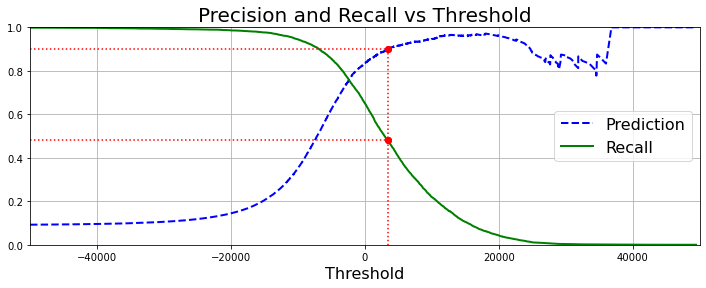

In [52]:
plt.figure(figsize=(12, 4))
plt.plot(sgd_thresholds, sgd_precisions[:-1], '--b', linewidth=2, label='Prediction')
plt.plot(sgd_thresholds, sgd_recalls[:-1], 'g-', linewidth=2, label='Recall')
plt.legend(loc='center right', fontsize=16)
plt.title('Precision and Recall vs Threshold', fontsize=20)
plt.xlabel('Threshold', fontsize=16)
plt.grid()
plt.axis([-50000, 50000, 0, 1])

sgd_precision_value = 0.90
sgd_threshold_value = sgd_thresholds[np.argmax(sgd_precisions >= sgd_precision_value)]
sgd_recall_value = sgd_recalls[np.argmax(sgd_thresholds >= sgd_threshold_value)]

plt.plot([-50000, sgd_threshold_value], [sgd_precision_value, sgd_precision_value], 'r:')
plt.plot([-50000, sgd_threshold_value], [sgd_recall_value, sgd_recall_value], 'r:')
plt.plot([sgd_threshold_value, sgd_threshold_value], [sgd_precision_value, 0], 'r:')

plt.plot([sgd_threshold_value, sgd_threshold_value], [sgd_precision_value, sgd_precision_value], 'ro')
plt.plot([sgd_threshold_value, sgd_threshold_value], [sgd_recall_value, sgd_recall_value], 'ro')

plt.show()

Using the chart above:
- We can see that as Precision increases, Recall decreases
- Precision curve is a little bumpier, that is because precision may sometimes decrease as we increase threshold
- We can find the prefect threshold for our analysis, by comparing the precision and recall at that given threshold

##### Precision/Recall
Another way to select a good precision/recall tradeoff is to plot precision directly with recall:

[]

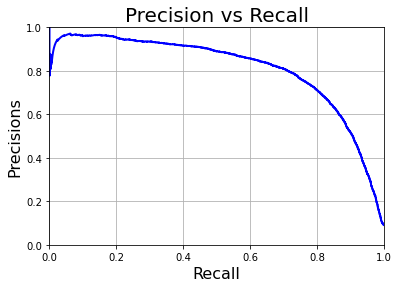

In [62]:
plt.plot(sgd_recalls, sgd_precisions, 'b-', linewidth=2)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precisions', fontsize=16)
plt.title('Precision vs Recall', fontsize=20)
plt.axis([0, 1, 0, 1])
plt.grid()
plt.plot()

Looking at the above chart:
- Precision falls sharply around 0.8 (80%) recall
- We would choose a precision/recall tradeoff just before that drop off

Let's suppose we decided to aim for a 90% precision value. We can look at the first plot to find out the threshold we need. To get a precise value, we can search for the lowest threshold that gives us at least 90% precision value using `np.argmax()` method. This gives us the first index of the maximum value.

In [65]:
sgd_threshold_90_precision = sgd_thresholds[np.argmax(sgd_precisions >= 0.90)]
print(f'Threshold value for 90% Precision: {round(sgd_threshold_90_precision, 2)}')

Threshold value for 90% Precision: 3370.02


Now, in order to make predicions using this threshold, instead of calling the classifier's `predict()` method, we can just compare the scores with the threshold

In [66]:
sgd_y_train_pred_90 = (sgd_y_scores >= sgd_threshold_90_precision)

Now let's check the scores:

In [67]:
print('Precision: ', precision_score(y_train_5, sgd_y_train_pred_90))
print('Recall: ', recall_score(y_train_5, sgd_y_train_pred_90))

Precision:  0.9000345901072293
Recall:  0.4799852425751706


##### ROC Curve

In [68]:
from sklearn.metrics import roc_curve

sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(y_train_5, sgd_y_scores)

Now let's plot the graph:

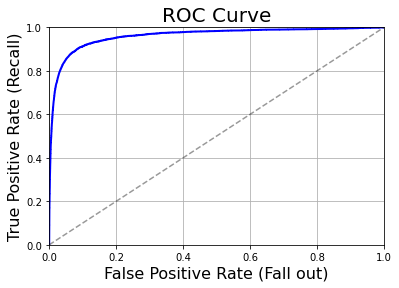

In [75]:
plt.plot(sgd_fpr, sgd_tpr, 'b-', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.4)

plt.xlabel('False Positive Rate (Fall out)', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.title('ROC Curve', fontsize=20)
plt.grid()
plt.axis([0, 1, 0, 1])
plt.show()

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have ROC AUC = 1, whereas a purely random classifier with have ROC AUC = 0.5

Scikit-Learn provides a method `roc_auc_score()` to compute this value:

In [76]:
from sklearn.metrics import roc_auc_score
sgd_auc_score = roc_auc_score(y_train_5, sgd_y_scores)
print('ROC AUC Score: ', round(sgd_auc_score, 2))

ROC AUC Score:  0.96


_**NOTE:**
Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the topright corner)._

#### Random Forest Classifer:

_RandomForestClassifier does not have a `decision_function()` method. Instead, it has `predict_proba()` method. Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (eg: 70% chance that the image represents a 5)_

In [77]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_y_probas = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In order to plot the ROC curve we need scores, not probabilites. A simple solution is to use the positive class's probability as the score:

In [80]:
forest_y_scores = forest_y_probas[:, 1]
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_train_5, forest_y_scores)

Now let's plot the ROC Curve:

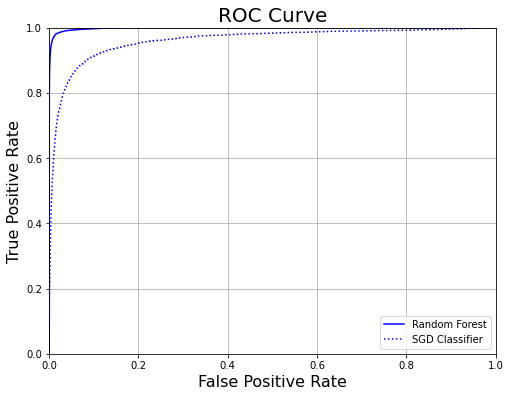

In [85]:
plt.figure(figsize=(8, 6))
plt.plot(forest_fpr, forest_tpr, 'b-', label='Random Forest')
plt.plot(sgd_fpr, sgd_tpr, 'b:', label='SGD Classifier')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc='lower right')
plt.axis([0, 1, 0, 1])
plt.grid()
plt.show()

From the above chart:
- We can see that the Random Forest Classifier's ROC is much closer to the corner, suggesting that Random Forest Classifier is better than SGD Classifier

Now let's calculate the AUC Score and compare with SGD Classifier

In [86]:
forest_auc_score = roc_auc_score(y_train_5, forest_y_scores)
print(f'Forest AUC Score: {forest_auc_score:.3f}\nSGD AUC Score: {sgd_auc_score:.3f}')

Forest AUC Score: 0.998
SGD AUC Score: 0.960


Here we can see:
- AUC for Random Forest is higher compared to SGD Classifer

Let's calculate Precision, Recall and F1 Scores for Random Forest:

_In order to these, we need predictions instead of scores_

In [87]:
forest_y_train_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [88]:
forest_precision = precision_score(y_train_5, forest_y_train_pred)
forest_recall = recall_score(y_train_5, forest_y_train_pred)
forest_f1score = f1_score(y_train_5, forest_y_train_pred)

print(f'Precision: {forest_precision:.2%}')
print(f'Recall: {forest_recall:.2%}')
print(f'F1 Score: {forest_f1score:.2%}')

Precision: 99.05%
Recall: 86.63%
F1 Score: 92.42%


#### Multiclass Classification

##### SGD Classifier

In [89]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

That was easy! This code trains the `SGDClassifier` on the training set using the original target classes from 0 to 9, instead of the 5-versus-all target classes. Then it makes prediction (a wrong one in this case). Under the hood, Scikit-Learn acutally traiined 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

To see that, we can call the `decision_function()` method. Instead of returning just one score per instance, it now returns 10 scores, one per each class:

In [90]:
some_digit_scores = sgd_clf.decision_function([some_digit])
print('Scores:', some_digit_scores)
print('Classes:', sgd_clf.classes_)
print('Output Class:', sgd_clf.classes_[np.argmax(some_digit_scores)])

Scores: [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
Classes: [0 1 2 3 4 5 6 7 8 9]
Output Class: 3


Here, we see that we have 10 scores and the highest score belongs to the class 3.

_**NOTE:**
When a classifier is trained, it stores the list of classes in its `classes` attribute, ordered by value. In this case, the index of each class in the `classes` array conveniently matches the class itself, but in general we won't be so lucky._

If you want to force Scikit-Learn to use OvO or OvA, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance and pass a binary classifier to its constructor. For example, this code creates a multicalss classifier using OvO strategy, based on `SGDClassifier`:

In [91]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(estimator=SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

__NOTE:__ When using `SGDClassifier` as OvO it predicted the some_digit correctly

In [92]:
print('Length of the estimator', len(ovo_clf.estimators_))

Length of the estimator 45


##### Random Forest Classifier

In [93]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

This time Scikit-Learn did not have to run OvA or OvO because Random Forest Classifier can directly classify instances into multiple classes. We can call the `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [94]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

We can see that the classifier is fairly confident about it's prediction: the 0.9 at the 5th index in the array means that the model estimates a 90% probability that the image represents a 5. It also thinks that the image could instead be a 2, a 3, or a 9, respectively with 1%, 8% and 1% probability.

Evaluating the performance of this classifier:

In [97]:
from sklearn.model_selection import cross_val_score

cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9646 , 0.96255, 0.9666 ])

As we can see, Random Forest Classifier is over 96% accurate on all the test folds, which is not a bad score. We can still fine tune it using various hyperparameters.

##### Error Analysis

Let's look at the confusion matrics. In order to do so, we need predictions

In [98]:
y_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=5)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5846    2    7    2    4    6   19    1   32    4]
 [   1 6636   32   16   15    4    7   15   10    6]
 [  24   11 5756   30   31    2   19   39   39    7]
 [   8    6   84 5815    2   66    8   53   61   28]
 [  12   12   11    0 5670    0   20   11   17   89]
 [  25    7   11   58    9 5210   41    5   32   23]
 [  25   11    1    0    8   33 5818    0   22    0]
 [   4   22   64    6   41    1    1 6044   13   69]
 [  11   28   35   52   26   49   25    6 5553   66]
 [  24   11   16   80   70   18    4   51   36 5639]]


It's often easier to visualize the confusion matrix. Let's try that:

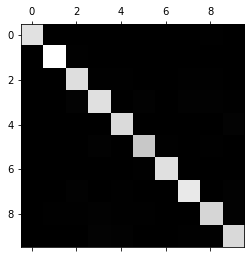

In [103]:
plt.matshow(conf_mx, cmap='gray')
plt.show()

The confusion matrix looks good since majority of the values are on the diagonal line. 
Let's focus the plot on the errors. First, we need to divide each value in the confusion matrix by the number of images in the corresponding class, so we can compare error rates instead of absolute number of errors

In [105]:
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx/row_sums

Now let's fill the diagonal with zeros to keep only the errors, and plot the result:

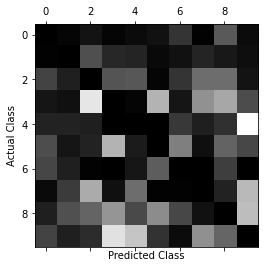

In [110]:
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap='gray')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

## Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases we may want our classifier to output multiple classes for each instance. For example, consider a face-recognition classifier: what sould it do if it recognizes several people on the same picture? Of course it should attach one tag per person it recognizes. Say the classifier has been trained to recognize three faces, Jack, Jill and John; then when it is shown a picture of Jack and Jill, it should output (1, 1, 0) (meaning "Jack Yes, Jill Yes, John No"). Such a classification system that outputs multiple binary tags is called Multilabel Classification Sysytem.

Let's look at a simple example which detects if the number is greater than 7 and is Odd or Even. For this example, we will be using `KNeighborsClassifier`:

In [111]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

_**NOTE:** KNeighborsClassifier supports multilabel classification, but not all classifiers do._

Let's predict the some_digit using the above classifier

In [112]:
knn_clf.predict([some_digit])

array([[False,  True]])

We can see there are two predictions:
- 1st Prediction (False) is correct as "5" is not larger than "7"
- 2nd Prediction (True) is correct as "5" is an odd number

##### Evaluating Multilabel Classifiers
There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on our project. For example, one approach is to measure F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score.

We need predictions in order to calculate the F1 Score, so let's get that first:

In [113]:
# The following code took more than 50 mins to run
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

Now, let's calculate the F1 Score

In [114]:
knn_f1_score = f1_score(y_multilabel, y_train_knn_pred, average='macro')
print(f'KNN F1 Score: {knn_f1_score: .2%}')

KNN F1 Score:  97.64%


This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Jill than of Jack and John, you may want to give more weight to the classifier's score on pictures of Jill. One simple option is to give each label a weight equal to its support (i.e., the number of instances with that target label). To do this simply set `average='weighted'` in the preceding code.

#### Multioutput Classification

It is also known as **Multioutput Multiclass Classification**. It is simply a generalization of multilabel classification where each label can be a multiclass (i.e., it can have more than two possible values).

To illustrate this, let's build a system that removes noise from images. It will take as input a noisy digit image, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of Multioutput Classification system.

Let's start by creating the training and test sets by taking MNIST images and adding noise to their pixel intensities unsing NumPy's `randint()` function. The target images will be the original images.

In [115]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Let's look at the images before the noise reduction algorithm:

(-0.5, 27.5, 27.5, -0.5)

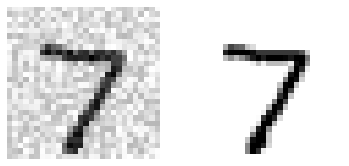

In [119]:
some_index = 0
noise_image = X_test_mod[some_index].reshape(28, 28)
image = y_test_mod[some_index].reshape(28, 28)

plt.subplot(121); plt.imshow(noise_image, cmap='binary')
plt.axis('off')
plt.subplot(122); plt.imshow(image, cmap='binary')
plt.axis('off')

On the left is the noisy input image, and on the right is the clean target image. Now let's train the classifer and make it clean this image

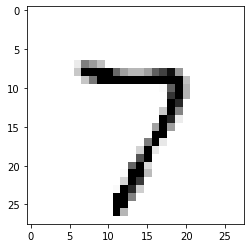

In [120]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]]).reshape(28, 28)
plt.imshow(clean_digit, cmap='binary')